In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from yahoo_fin.stock_info import get_data
import yfinance as yf
import seaborn as sns


In [2]:
# Extracting data from csv files to DataFrame

def extract_first_non_nan(lst):              # Custom function to extract the first non-NaN value from a list or single value
    if isinstance(lst, list):
        for item in lst:
            if not pd.isna(item):
                return item
    else:  # Handle single values
        if not pd.isna(lst):
            return lst
    return np.nan

dfs = []

directory = r'C:\Users\Rushi\Desktop\Finance_Project_course\Economic_terms'  # add path to the CSV file
os.chdir(directory)                        # Change the current working directory to the directory containing the CSV files

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'): 
        df = pd.read_csv(filename, skiprows=15)                # Read the CSV file and skip the first 15 rows
        df['Year'] = pd.to_datetime(df['date'], format='%d-%m-%Y').dt.year
        dfs.append(df)


combined_df = pd.concat(dfs, ignore_index=True)

# Group by year and apply the custom function to each cell
final_df = combined_df.groupby('Year').agg(lambda x: extract_first_non_nan(x.tolist())).reset_index()

years_df = pd.DataFrame({'Year': range(2000, 2024)})
final_df = pd.merge(years_df, final_df, on='Year', how='left')

# Rename few columns
final_df = final_df.rename(columns={' value': 'National debt Growth by year'})

# Drop the columns
final_df.drop(columns=['date',' Annual Change',' ', ' Annual Growth % Change', ' Change', ' Annual % Growth rate'], inplace=True)
final_df = final_df.fillna(final_df.median())            # Filling the NaN values with the median to retain the sanity of values
final_df.head()


,Year,National debt Growth by year,Government Debt as % of GDP,GDP ( Billions of US $),Per Capita (US $),GNI (Billions of US $),Per Capita (US $),Inflation Rate (%),% Under US $5.50 Per Day,Unemployment Rate (%),% of Total Labor Force Ages 15-24
0,2000,-1.97,33.2677,10250.94800,36329.9561,10146.58426,35960.0,3.3769,1.5,3.99,9.275
1,2001,4.97,52.4437,10581.92977,37133.6231,10459.33459,36700.0,2.8262,1.7,4.73,10.496
2,2002,7.78,53.8625,10929.11296,37997.7597,10730.15094,37310.0,1.5860,1.7,5.78,11.922
3,2003,9.25,56.2504,11456.44204,39490.2750,11533.12878,39750.0,2.2701,2.0,5.99,12.345
4,2004,8.55,56.6623,12217.19320,41724.6316,12740.19179,43510.0,2.6772,2.0,5.53,11.792


### Above is the extracted data from macrotrends

In [3]:
# Initializing the ticker

tickers = [
    'AAPL', 'AEP', 'PLD', 'CVX', 'GS', 'MMM', 'NKE', 'RIO', 'T', 'UNH', 'WMT'       # input the ticker symbol
]
date_list = final_df['Year'].tolist()
yearly_diff_data_list = []

In [4]:
# Getting stock data, yearly average 
for year in date_list:
    
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    yearly_diff_data = {'Year': year}        # Initialize a dictionary to store the differences for each ticker
    
    for ticker in tickers:
        data = yf.Ticker(ticker).history(start=start_date, end=end_date)
        
        # Calculate the difference between the highest and lowest prices for the current ticker
        yearly_high = data['High'].max()
        yearly_low = data['Low'].min()
        yearly_diff_data[ticker] = (yearly_high + yearly_low)/2
    
    yearly_diff_data_list.append(yearly_diff_data)

# Convert the list of dictionaries to a DataFrame
yearly_diff_df = pd.DataFrame(yearly_diff_data_list)
yearly_diff_df.head()


,Year,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
0,2000,0.671327,13.627707,9.263939,17.101929,73.437876,19.113609,4.007995,5.168020,6.920249,8.707183,11.974094
1,2001,0.314130,16.992670,10.833450,18.853716,66.542029,20.714673,4.628159,4.959993,6.741347,12.399303,11.009748
2,2002,0.298804,12.752306,12.763812,17.318582,56.857425,23.076983,5.022416,5.375451,4.684612,16.987723,11.791564
3,2003,0.285198,10.935412,14.655834,17.112951,59.783082,29.706289,5.437087,6.980595,4.071782,19.615669,11.731791
4,2004,0.685972,14.781010,18.079363,23.382467,72.618498,34.162411,7.827560,8.086416,4.549952,28.927556,12.471998


### Above data is from yahoo finance

In [5]:
# Making a ridge Linear regression model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Lists to store performance metrics
tickers = []
train_rmse_list = []
test_rmse_list = []
train_r2_list = []
test_r2_list = []

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

for ticker in yearly_diff_df.columns[1:]:  # Exclude the 'Year' column
    X = final_df.drop(columns=['Year'])    # Assuming Year is not a feature
    y = yearly_diff_df[[ticker]]           # Select the column corresponding to the current ticker
    
    # Transforming features and appling appropiate signs
    X_scaled = scaler.fit_transform(X)
    original_signs = np.sign(X.values)
    
    for i in range(X.shape[0]):  # Iterate through rows
        for j in range(X.shape[1]):  # Iterate through columns
            if original_signs[i, j] == -1:  # Check if original value was negative
                X_scaled[i, j] *= -1  # Apply negative sign to corresponding scaled feature
    
    y_scaled = scaler.fit_transform(y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=86)
    
    model = Ridge(alpha=1)  
    model.fit(X_train, y_train)
    
    # Evaluate the model's performance
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    train_rmse = root_mean_squared_error(y_train, train_predictions)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    
    tickers.append(ticker)
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)

# DataFrame to display performance metrics
performance_df = pd.DataFrame({
    'Ticker': tickers,
    'Train RMSE': train_rmse_list,
    'Test RMSE': test_rmse_list,
    'Train R-squared': train_r2_list,
    'Test R-squared': test_r2_list
})
performance_df



,Ticker,Train RMSE,Test RMSE,Train R-squared,Test R-squared
0,AAPL,0.118927,0.257105,0.748200,0.620690
1,AEP,0.068883,0.091641,0.943621,0.929125
2,PLD,0.100590,0.176400,0.821535,0.777699
3,CVX,0.057616,0.203902,0.915372,0.625944
4,GS,0.099756,0.170685,0.813618,0.770007
5,MMM,0.103996,0.220040,0.912300,0.056633
6,NKE,0.105303,0.060671,0.853256,0.957636
7,RIO,0.094236,0.175703,0.841675,0.750683
8,T,0.099552,0.172076,0.920545,0.717658
9,UNH,0.082405,0.235383,0.868823,0.668431


In [6]:
# Sanity check, for tranform X data, not important for the model (optional)

inverse_transformed_columns = []
for i, (col_name, col) in enumerate(X.items()):
    if original_signs[:, i].any() == -1:
        inverse_transformed_column = scaler.inverse_transform(X_scaled[:, i].reshape(-1, 1))
        inverse_transformed_columns.append(pd.Series(inverse_transformed_column.flatten(), name=col_name))
    else:
        inverse_transformed_columns.append(col)
X_inverse_df = pd.concat(inverse_transformed_columns, axis=1)

X_inverse_df.head()

,National debt Growth by year,Government Debt as % of GDP,GDP ( Billions of US $),Per Capita (US $),GNI (Billions of US $),Per Capita (US $),Inflation Rate (%),% Under US $5.50 Per Day,Unemployment Rate (%),% of Total Labor Force Ages 15-24
0,-1.97,33.2677,10250.94800,36329.9561,10146.58426,35960.0,3.3769,1.5,3.99,9.275
1,4.97,52.4437,10581.92977,37133.6231,10459.33459,36700.0,2.8262,1.7,4.73,10.496
2,7.78,53.8625,10929.11296,37997.7597,10730.15094,37310.0,1.5860,1.7,5.78,11.922
3,9.25,56.2504,11456.44204,39490.2750,11533.12878,39750.0,2.2701,2.0,5.99,12.345
4,8.55,56.6623,12217.19320,41724.6316,12740.19179,43510.0,2.6772,2.0,5.53,11.792


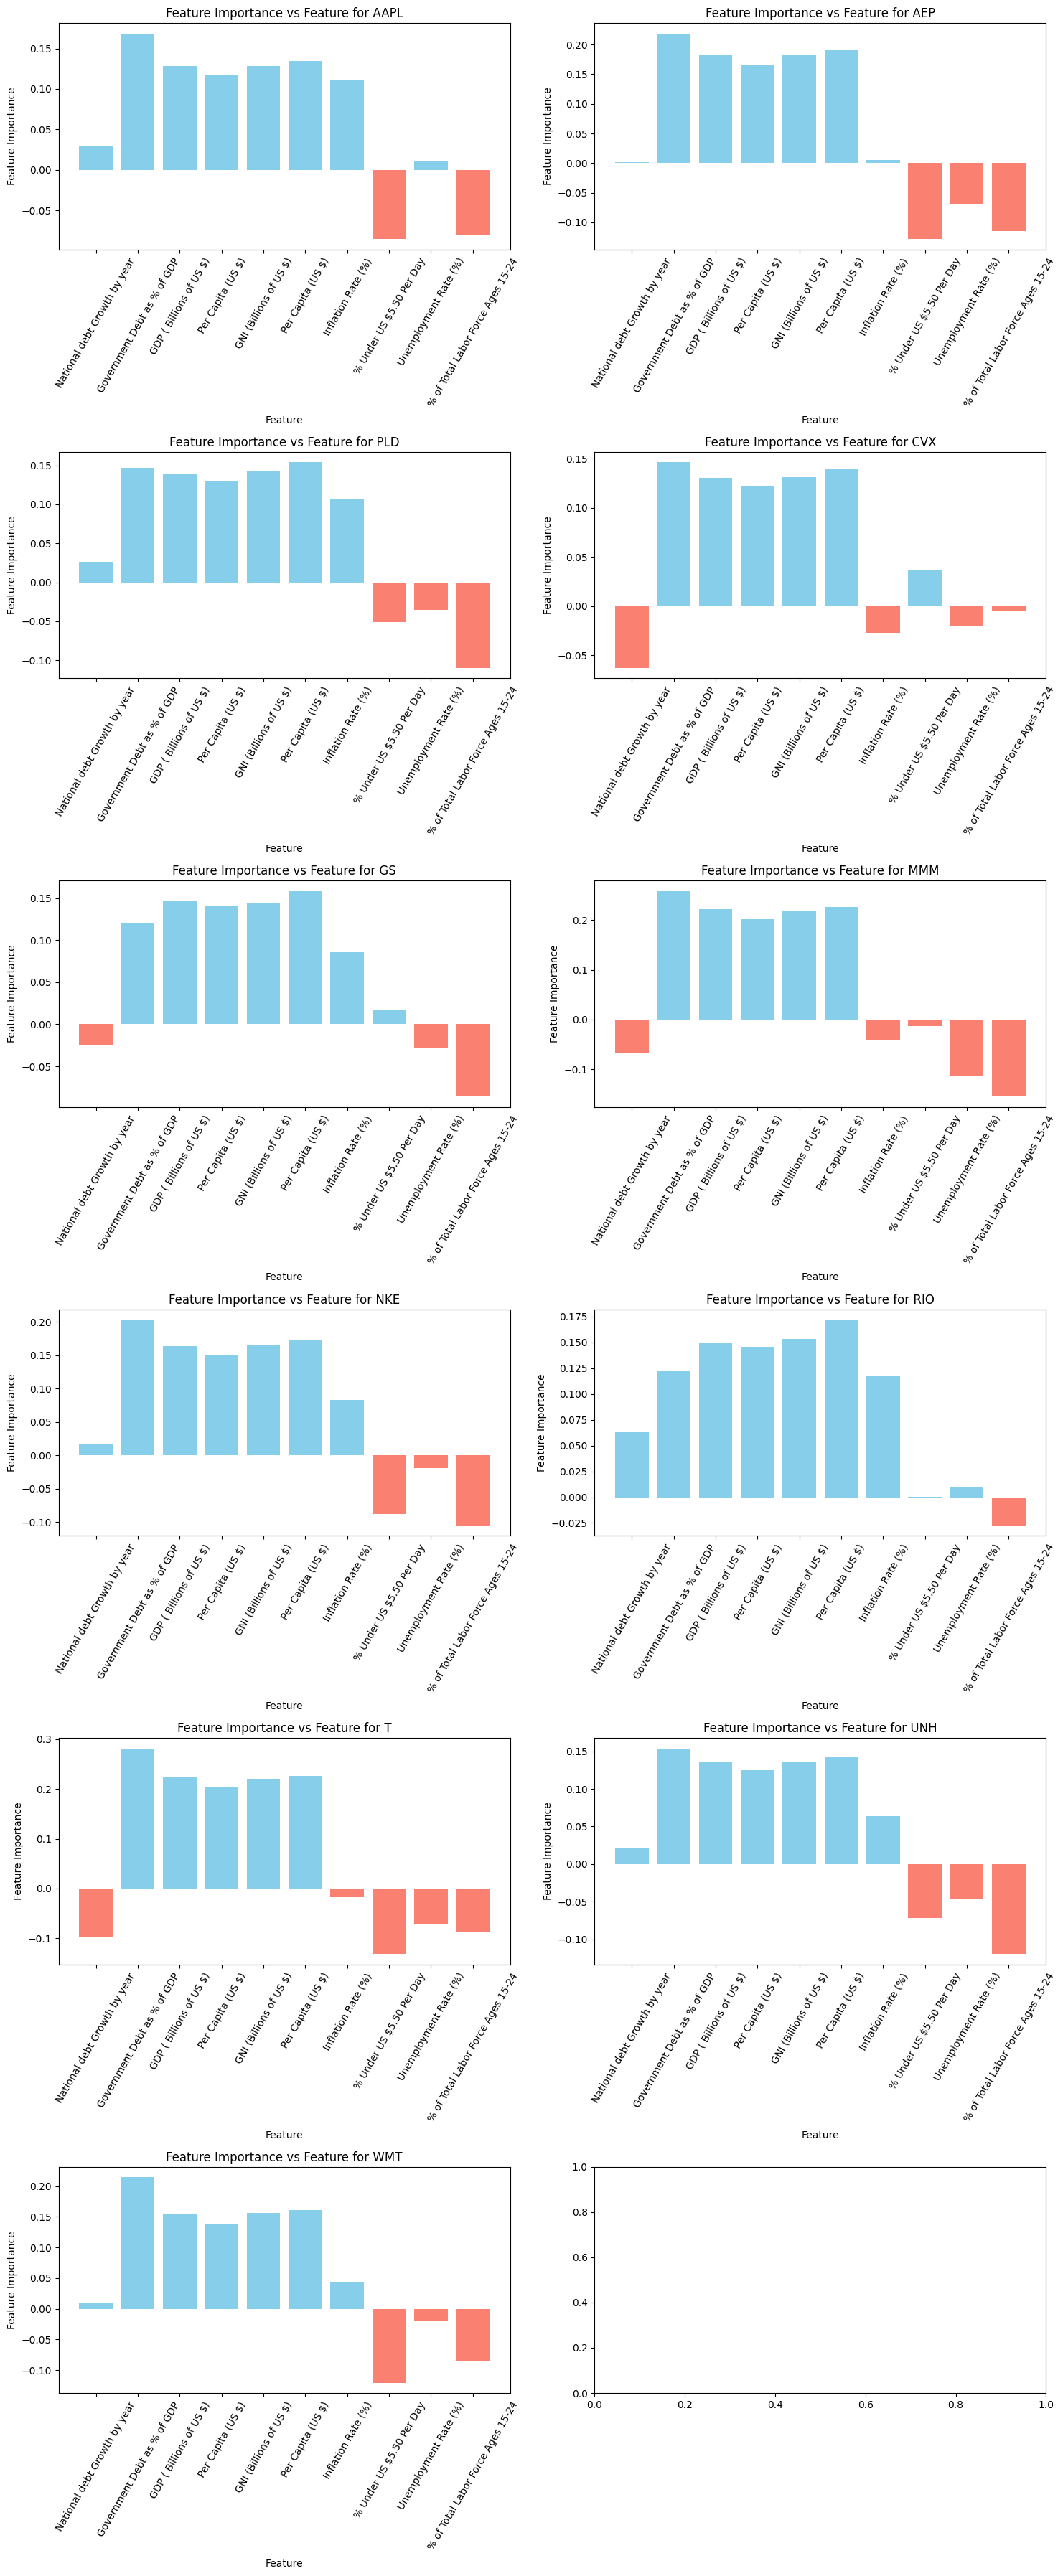

In [7]:
# Ploting the feature importance for all ticker

scaler = MinMaxScaler(feature_range=(0, 1))
feature_importance_dfs = {}
tickers = yearly_diff_df.columns[1:]  # Exclude the 'Year' column
num_plots = len(tickers)
num_rows = (num_plots + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 6 * num_rows))

for i, ticker in enumerate(tickers):
    ax = axes[i // 2, i % 2]  # Select subplot
    X = final_df.drop(columns=['Year'])  # Assuming Year is not a feature
    y = yearly_diff_df[[ticker]]  # Select the column corresponding to the current ticker
    
    # Fit and transform features
    X_scaled = scaler.fit_transform(X)
    original_signs = np.sign(X.values)
    
    for i in range(X.shape[0]):  # Iterate through rows
        for j in range(X.shape[1]):  # Iterate through columns
            if original_signs[i, j] == -1:  # Check if original value was negative
                X_scaled[i, j] *= -1  # Apply negative sign to corresponding scaled feature

    y_scaled = scaler.fit_transform(y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=86)
    
    # Train a Ridge regression model with regularization
    model = Ridge(alpha=1)  
    model.fit(X_train, y_train)
    
    # Retrieve feature importance
    feature_importance = model.coef_[0]
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    })

    feature_importance_dfs[ticker] = feature_importance_df
    
    # Plot feature importance vs feature
    ax.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], 
           color=['skyblue' if imp >= 0 else 'salmon' for imp in feature_importance_df['Importance']])
    ax.set_xlabel('Feature')
    ax.set_ylabel('Feature Importance')
    ax.set_title(f'Feature Importance vs Feature for {ticker}')
    ax.tick_params(axis='x', rotation=60)

# Adjust layout
plt.tight_layout()
plt.show()


In [8]:
# Displaying feature importance

feature_importance_df = pd.DataFrame(columns=feature_importance_dfs[tickers[0]]['Feature'])
feature_importance_df.index.name = 'Ticker'

for ticker, df in feature_importance_dfs.items():
    feature_importance_df.loc[ticker] = df.set_index('Feature')['Importance']

feature_importance_df.head() # this is features vs ticker dataframe

Feature,National debt Growth by year,Government Debt as % of GDP,GDP ( Billions of US $),Per Capita (US $),GNI (Billions of US $),Per Capita (US $),Inflation Rate (%),% Under US $5.50 Per Day,Unemployment Rate (%),% of Total Labor Force Ages 15-24
Ticker,,,,,,,,,,
AAPL,0.030321,0.168534,0.128069,0.117535,0.128700,0.134671,0.111825,-0.085545,0.011203,-0.080765
AEP,0.002024,0.218791,0.182579,0.166725,0.183060,0.190826,0.005618,-0.128140,-0.068988,-0.114897
PLD,0.026712,0.146558,0.138068,0.130490,0.141729,0.153992,0.106357,-0.050706,-0.034884,-0.109489
CVX,-0.062850,0.146522,0.130689,0.121817,0.131103,0.139852,-0.027076,0.036826,-0.020344,-0.005195
GS,-0.024877,0.119528,0.145838,0.140103,0.144312,0.158427,0.085789,0.017576,-0.027963,-0.085953


### Obtained feature importance from the linear regression model

In [9]:
# Making Year vs features dataframe
factors_df = final_df.copy()
factors_df.reset_index(drop=True, inplace=True)
factors_df = factors_df.transpose()
factors_df.columns = factors_df.iloc[0]  # Set the first row as column names
factors_df = factors_df[1:]  # Exclude the first row (previously used as column names)
#factors_df.head()

In [10]:
# scaling down the features as the model is trained on scaled downed feature
factors_df_transposed = factors_df.transpose()
scaler = MinMaxScaler(feature_range=(0,1))
factors_df_scaled = pd.DataFrame(scaler.fit_transform(factors_df_transposed), columns=factors_df_transposed.columns, index=factors_df_transposed.index)
factors_df_scaled.head()  # this is features vs Year dataframe

,National debt Growth by year,Government Debt as % of GDP,GDP ( Billions of US $),Per Capita (US $),GNI (Billions of US $),Per Capita (US $),Inflation Rate (%),% Under US $5.50 Per Day,Unemployment Rate (%),% of Total Labor Force Ages 15-24
Year,,,,,,,,,,
2000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.446550,0.3,0.064677,0.132211
2001.0,0.321743,0.206272,0.019345,0.017198,0.018415,0.018312,0.380664,0.5,0.187396,0.249019
2002.0,0.452017,0.221533,0.039638,0.035690,0.034361,0.033408,0.232284,0.5,0.361526,0.385440
2003.0,0.520167,0.247219,0.070459,0.067629,0.081641,0.093789,0.314131,0.8,0.396352,0.425906
2004.0,0.487714,0.251650,0.114924,0.115443,0.152714,0.186835,0.362837,0.8,0.320066,0.373003


In [11]:
factors_df_scaled = factors_df_scaled.transpose()  # Year vs features dataframe

In [12]:
# Matrix multiplication
predicted_data = feature_importance_df.dot(factors_df_scaled)
predicted_data =predicted_data.transpose()
predicted_data.head()   # to get ticker vs year dataframe

Ticker,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000.0,0.014319,-0.055586,0.015550,-0.003045,0.030409,-0.049926,-0.004352,0.049467,-0.063822,-0.011811,-0.028728
2001.0,0.035637,-0.044425,0.030501,0.022601,0.042241,-0.033804,0.017469,0.096839,-0.065476,-0.001601,-0.009287
2002.0,0.025357,-0.056755,0.009225,0.025522,0.021743,-0.058063,0.004236,0.098333,-0.080255,-0.020956,-0.015592
2003.0,0.034281,-0.064901,0.027079,0.055477,0.056319,-0.036114,0.014359,0.141645,-0.089195,-0.015156,-0.019674
2004.0,0.075900,-0.005526,0.077276,0.092640,0.106696,0.038222,0.068001,0.187016,-0.019045,0.032817,0.028697


In [13]:
# actual data
yearly_diff_df.set_index("Year", inplace=True)
yearly_diff_df.head()

,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000,0.671327,13.627707,9.263939,17.101929,73.437876,19.113609,4.007995,5.168020,6.920249,8.707183,11.974094
2001,0.314130,16.992670,10.833450,18.853716,66.542029,20.714673,4.628159,4.959993,6.741347,12.399303,11.009748
2002,0.298804,12.752306,12.763812,17.318582,56.857425,23.076983,5.022416,5.375451,4.684612,16.987723,11.791564
2003,0.285198,10.935412,14.655834,17.112951,59.783082,29.706289,5.437087,6.980595,4.071782,19.615669,11.731791
2004,0.685972,14.781010,18.079363,23.382467,72.618498,34.162411,7.827560,8.086416,4.549952,28.927556,12.471998


In [14]:
# Scaling down the yearly_diff_df(actual scaled down data)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(yearly_diff_df)
yearly_diff_scaled = pd.DataFrame(scaled_data, columns=yearly_diff_df.columns, index = yearly_diff_df.index)
yearly_diff_scaled.head()


,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000,0.002397,0.035175,0.000000,0.000000,0.059610,0.000000,0.000000,0.003534,0.210252,0.000000,0.029904
2001,0.000180,0.079139,0.013045,0.012367,0.034818,0.013458,0.004316,0.000000,0.197047,0.007581,0.005551
2002,0.000084,0.023738,0.029090,0.001529,0.000000,0.033314,0.007059,0.007058,0.045234,0.017003,0.025295
2003,0.000000,0.000000,0.044816,0.000078,0.010518,0.089036,0.009945,0.034326,0.000000,0.022399,0.023785
2004,0.002488,0.050243,0.073271,0.044338,0.056664,0.126491,0.026580,0.053111,0.035295,0.041520,0.042478


In [15]:
# Writing the inverse function for actual to scale up the actual scaled down data
actual_data = scaler.inverse_transform(yearly_diff_scaled)
actual_df = pd.DataFrame(actual_data, columns=yearly_diff_scaled.columns, index=yearly_diff_scaled.index)
actual_df.head()

,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000,0.671327,13.627707,9.263939,17.101929,73.437876,19.113609,4.007995,5.168020,6.920249,8.707183,11.974094
2001,0.314130,16.992670,10.833450,18.853716,66.542029,20.714673,4.628159,4.959993,6.741347,12.399303,11.009748
2002,0.298804,12.752306,12.763812,17.318582,56.857425,23.076983,5.022416,5.375451,4.684612,16.987723,11.791564
2003,0.285198,10.935412,14.655834,17.112951,59.783082,29.706289,5.437087,6.980595,4.071782,19.615669,11.731791
2004,0.685972,14.781010,18.079363,23.382467,72.618498,34.162411,7.827560,8.086416,4.549952,28.927556,12.471998


In [16]:
# Using the inverse function on the predicted data to scale up
original_predicted_data = scaler.inverse_transform(predicted_data)
original_predicted_df = pd.DataFrame(original_predicted_data, columns=predicted_data.columns, index=predicted_data.index)
original_predicted_df.head()

Ticker,AAPL,AEP,PLD,CVX,GS,MMM,NKE,RIO,T,UNH,WMT
Year,,,,,,,,,,,
2000.0,2.591347,6.680903,11.134766,16.670536,65.315821,13.173891,3.382530,7.871910,3.207134,2.955080,9.652385
2001.0,6.024865,7.535176,12.933566,20.303317,68.606852,15.091884,6.518398,10.660450,3.184721,7.927522,10.422226
2002.0,4.369148,6.591429,10.373784,20.717093,62.905320,12.205760,4.616743,10.748374,2.984500,-1.498412,10.172550
2003.0,5.806441,5.967893,12.521921,24.960252,72.522620,14.817075,6.071484,13.297966,2.863383,1.325969,10.010913
2004.0,12.509637,10.512423,18.561111,30.224431,86.535027,23.660974,13.779969,15.968731,3.813762,24.689056,11.926284


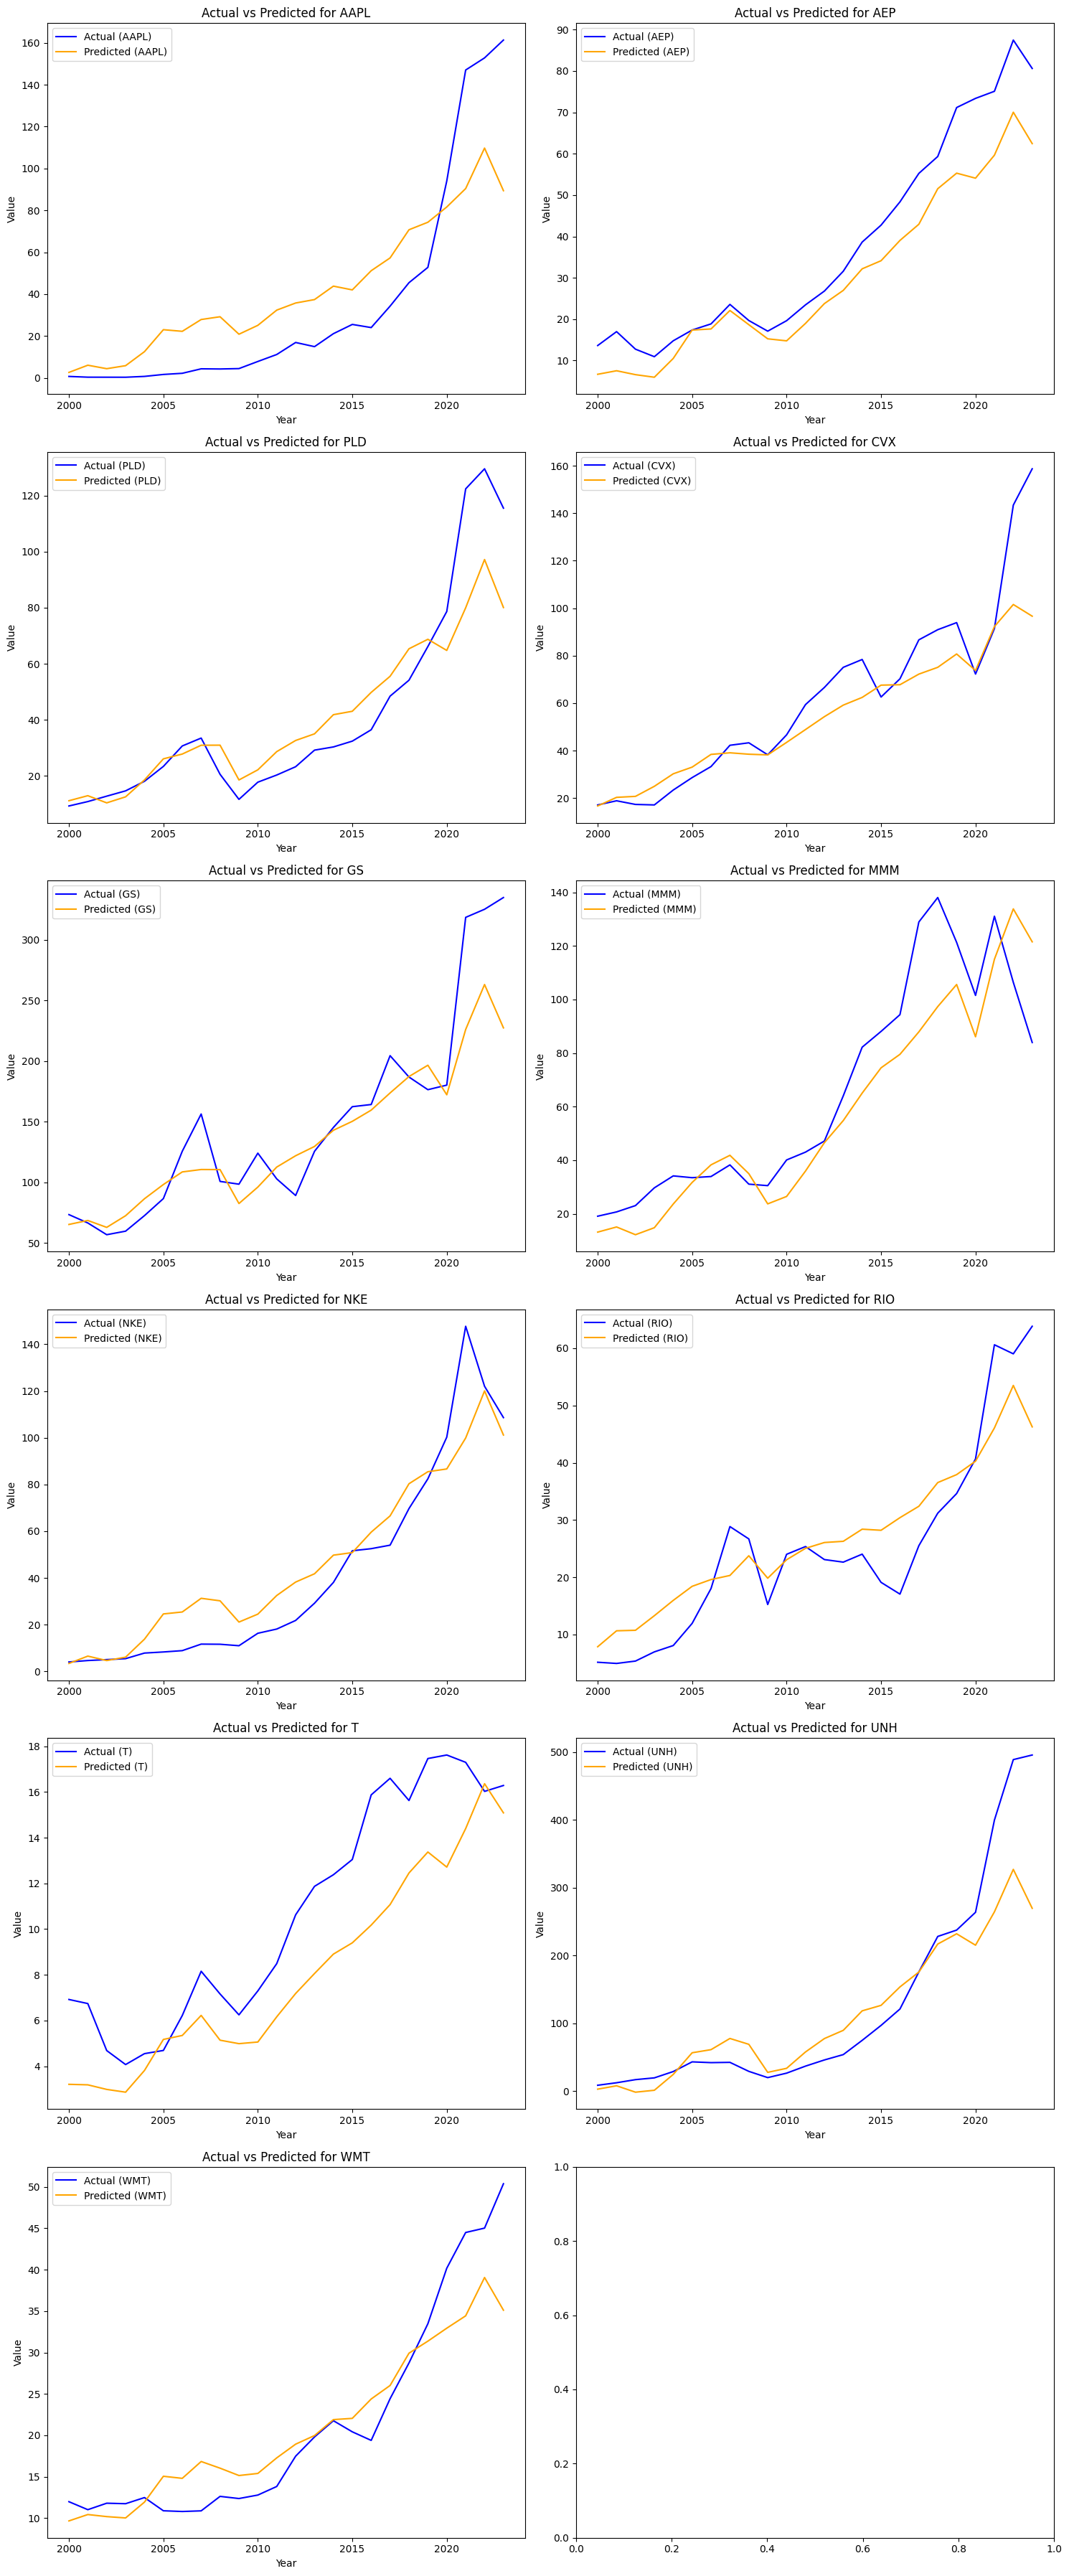

In [17]:
# Plotting actual vs predicted

num_tickers = len(actual_df.columns)
num_rows = (num_tickers + 1) // 2  
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
axes = axes.flatten()


for i, (ticker, ax) in enumerate(zip(actual_df.columns, axes)):
    ax.plot(actual_df.index, actual_df[ticker], label=f'Actual ({ticker})', color='blue')
    ax.plot(original_predicted_df.index, original_predicted_df[ticker], label=f'Predicted ({ticker})', color='orange')
    
    ax.set_title(f'Actual vs Predicted for {ticker}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()
